# 過学習と学習不足について知る

https://www.tensorflow.org/tutorials/keras/overfit_and_underfit?hl=ja

## 過学習(Overfiting)

モデルの訓練をやりすぎてしまい、テストデータには一般的ではないパターンを学習してしまう。その結果、一度ピークを迎えた検証用データでのモデルの正解率が、その後低下してしまう。

## 学習不足(Underfitting)

モデルがテストデータに対してまだ改善の余地がある状態。訓練用データの中の関連したパターンを学習しきっていないということを意味する。

学習不足の原因は様々で、モデルが十分強力でない、正則化のしすぎ、単に訓練時間が短すぎる、など。


## モデルの訓練が目指すところ

過学習と学習不足の中間を目指す必要がある。

過学習を防止するための、最良の解決策は、より多くの訓練用データを使うこと。多くのデータで訓練を行えば行うほど、モデルは自然により汎化していく。
これが不可能な場合、次善の策は、正則化のようなテクニックを使うこと。
正則化は、モデルに保存される情報の量とタイプに制約を課すもの。ネットワークが少数のパターンしか記憶できなければ、最適化プロセスにより、最も主要なパターンのみを学習することになり、より汎化される可能性が高くなる。

## 今回のチュートリアル

重みの正則化とドロップアウトという、よく使われる2つの正則化テクニックを使用する。
これらを使って、IMDBの映画レビューを分類するノートブックの改善を図る。

In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


## IMDBデータセットのダウンロード

以前のノートブックで使用したエンべディングの代わりに、ここでは文をマルチホットエンコードする。

このモデルは、訓練用データセットをすぐに過学習する。このモデルを使って、過学習がいつ起きるか、そしてどうやって過学習と戦うかをデモする。

 リストをマルチホットエンコードするというのは、0と1のベクトルにするということ。
 具体的には、例えば、`[3, 5]`というシーケンスを、インデックスが3と5の値が1で、それ以外がすべて0の10000次元のベクトルに変化するということを意味する。


In [10]:
NUM_WORDS = 10000

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

def multi_hot_sequences(sequences, dimension):
    # 形状が(len(sequences), dimension)ですべての0の行列を作る
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        # 特定のインデックスに対してresult[i]を1にする
        results[i, word_indices] = 1.0
    return results

train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)

結果として得られるマルチホットベクトルの1つを確認する。
単語のインデックスは頻度順にソートされている。このため、インデックスが0に近い単語ほど、1が多く出現するはず。分布を見て確認すること。

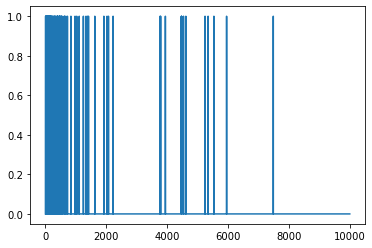

In [17]:
# インデックスを変えてプロットしていった時、インデックスが0に近いものほど1になっている頻度が高くなっているのが確認できる。
plt.plot(train_data[0])

## 過学習のデモ

### 比較基準を作る

In [18]:
baseline_model = keras.Sequential([
    # .summary を見るために、 input_shapeが必要
    keras.layers.Dense(16, activation="relu", input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

baseline_model.compile(optimizer="adam",
                       loss="binary_crossentropy",
                       metrics=["accuracy", "binary_crossentropy"])
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [19]:
baseline_history = baseline_model.fit(train_data,
                                      train_labels,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(test_data, test_labels),
                                      verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 3s - loss: 0.4516 - accuracy: 0.8167 - binary_crossentropy: 0.4516 - val_loss: 0.3162 - val_accuracy: 0.8789 - val_binary_crossentropy: 0.3162
Epoch 2/20
25000/25000 - 2s - loss: 0.2323 - accuracy: 0.9163 - binary_crossentropy: 0.2323 - val_loss: 0.2847 - val_accuracy: 0.8858 - val_binary_crossentropy: 0.2847
Epoch 3/20
25000/25000 - 2s - loss: 0.1735 - accuracy: 0.9379 - binary_crossentropy: 0.1735 - val_loss: 0.2954 - val_accuracy: 0.8839 - val_binary_crossentropy: 0.2954
Epoch 4/20
25000/25000 - 2s - loss: 0.1389 - accuracy: 0.9520 - binary_crossentropy: 0.1389 - val_loss: 0.3214 - val_accuracy: 0.8774 - val_binary_crossentropy: 0.3214
Epoch 5/20
25000/25000 - 2s - loss: 0.1138 - accuracy: 0.9637 - binary_crossentropy: 0.1138 - val_loss: 0.3532 - val_accuracy: 0.8726 - val_binary_crossentropy: 0.3532
Epoch 6/20
25000/25000 - 2s - loss: 0.0947 - accuracy: 0.9704 - binary_crossentropy: 0.0947 - val_loss: 0.3928

## より小さいモデルの構築

In [22]:
smaller_model = keras.Sequential([
    # .summary を見るために、 input_shapeが必要
    keras.layers.Dense(4, activation="relu", input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

smaller_model.compile(optimizer="adam",
                       loss="binary_crossentropy",
                       metrics=["accuracy", "binary_crossentropy"])
smaller_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


In [23]:
smaller_history = smaller_model.fit(train_data,
                                      train_labels,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(test_data, test_labels),
                                      verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 2s - loss: 0.6248 - accuracy: 0.6821 - binary_crossentropy: 0.6248 - val_loss: 0.5567 - val_accuracy: 0.8020 - val_binary_crossentropy: 0.5567
Epoch 2/20
25000/25000 - 2s - loss: 0.4784 - accuracy: 0.8585 - binary_crossentropy: 0.4784 - val_loss: 0.4371 - val_accuracy: 0.8606 - val_binary_crossentropy: 0.4371
Epoch 3/20
25000/25000 - 2s - loss: 0.3554 - accuracy: 0.9052 - binary_crossentropy: 0.3554 - val_loss: 0.3525 - val_accuracy: 0.8820 - val_binary_crossentropy: 0.3525
Epoch 4/20
25000/25000 - 2s - loss: 0.2729 - accuracy: 0.9222 - binary_crossentropy: 0.2729 - val_loss: 0.3095 - val_accuracy: 0.8874 - val_binary_crossentropy: 0.3095
Epoch 5/20
25000/25000 - 2s - loss: 0.2242 - accuracy: 0.9340 - binary_crossentropy: 0.2242 - val_loss: 0.2918 - val_accuracy: 0.8877 - val_binary_crossentropy: 0.2918
Epoch 6/20
25000/25000 - 2s - loss: 0.1932 - accuracy: 0.9405 - binary_crossentropy: 0.1932 - val_loss: 0.2856

## より大きなモデルの構築

練習として、より大きなモデルを作成し、どれほど急速に過学習が起きるかを確認する。

In [24]:
bigger_model = keras.Sequential([
    # .summary を見るために、 input_shapeが必要
    keras.layers.Dense(512, activation="relu", input_shape=(NUM_WORDS,)),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

bigger_model.compile(optimizer="adam",
                       loss="binary_crossentropy",
                       metrics=["accuracy", "binary_crossentropy"])
bigger_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


In [25]:
bigger_history = bigger_model.fit(train_data,
                                      train_labels,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(test_data, test_labels),
                                      verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 2s - loss: 0.3495 - accuracy: 0.8510 - binary_crossentropy: 0.3495 - val_loss: 0.3101 - val_accuracy: 0.8729 - val_binary_crossentropy: 0.3101
Epoch 2/20
25000/25000 - 2s - loss: 0.1462 - accuracy: 0.9470 - binary_crossentropy: 0.1462 - val_loss: 0.3248 - val_accuracy: 0.8750 - val_binary_crossentropy: 0.3248
Epoch 3/20
25000/25000 - 2s - loss: 0.0484 - accuracy: 0.9853 - binary_crossentropy: 0.0484 - val_loss: 0.4355 - val_accuracy: 0.8670 - val_binary_crossentropy: 0.4355
Epoch 4/20
25000/25000 - 2s - loss: 0.0067 - accuracy: 0.9988 - binary_crossentropy: 0.0067 - val_loss: 0.5887 - val_accuracy: 0.8686 - val_binary_crossentropy: 0.5887
Epoch 5/20
25000/25000 - 2s - loss: 7.7322e-04 - accuracy: 1.0000 - binary_crossentropy: 7.7322e-04 - val_loss: 0.6948 - val_accuracy: 0.8704 - val_binary_crossentropy: 0.6948
Epoch 6/20
25000/25000 - 2s - loss: 2.2158e-04 - accuracy: 1.0000 - binary_crossentropy: 2.2158e-04 - 

## 訓練時と検証時の損失をグラフにする

今回の場合では、小さいネットワークの方が比較基準のモデルよりも過学習が始まるのが遅いことがわかる。
また、過学習が始まっても性能の低下がゆっくりしている。

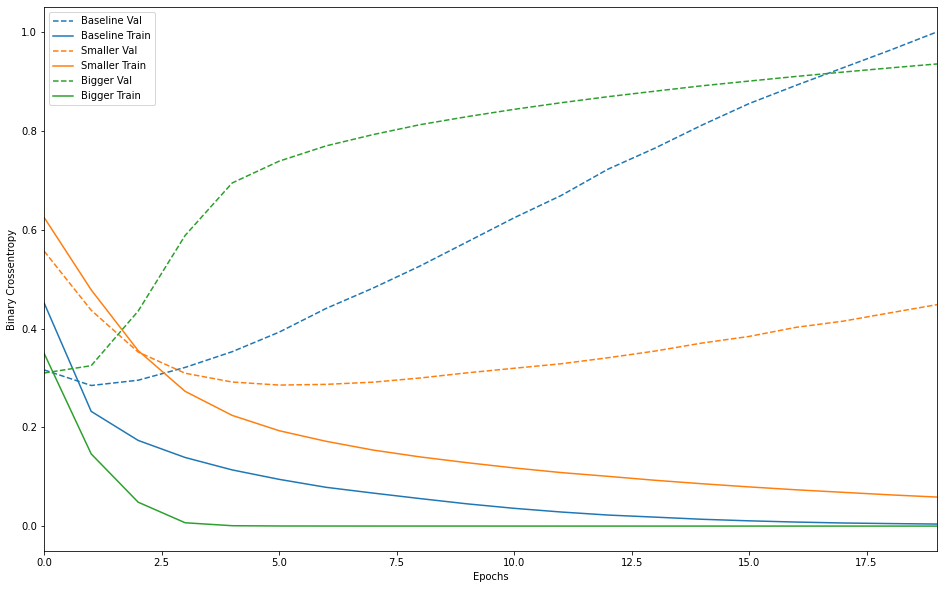

In [27]:
def plot_history(histories, key="binary_crossentropy"):
    plt.figure(figsize=(16, 10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history["val_"+key],
                       "--", label=name.title()+" Val")
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+" Train")
    plt.xlabel("Epochs")
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0, max(history.epoch)])

plot_history([("baseline", baseline_history),
              ("smaller", smaller_history),
              ("bigger", bigger_history)])

## 過学習防止の戦略

### 重みの正則化を加える

ある訓練用データとネットワーク構造があって、そのデータを説明できる重みの集合が複数ある時（つまり、複数のモデルがあるとき）、単純なモデルの方が複雑なものよりも過学習しにくい。

ここで言う「単純なモデル」とは、パラメータ値の分布のエントロピーが小さいもの（あるいは、上記で見たように、そもそもパラメータの数が小さいもの）。
したがって、過学習を緩和するための一般的な手法は、重みが小さい値のみをとることで、重み値の分布がより整然となる（正則）様に制約を与えること。
これは、「重みの正則化」と呼ばれ、ネットワークの損失関数に、重みの大きさに関連するコストを加えることで行われる。
このコストには2つの種類がある。

- L1正則化: 重み係数の絶対値に比例するコストを加える（重みの「L1ノルム」と呼ばれる）
- L2正則化: 重み係数の二乗に比例するコストを加える（重みの「L1ノルム」と呼ばれる）。L2正則化はニューラルネットワーク用語では、重み減衰（Weight Decay）と呼ばれる。

L1正則化は重みパラメータの一部を0にしてモデルを疎にする効果がある。L2正則化は重みパラメータにペナルティを加えるが、モデルを疎にすることはない。L2正則化の方が一般的に使用される。

In [28]:
l2_model = keras.models.Sequential([
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

l2_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'binary_crossentropy'])

l2_model_history = l2_model.fit(train_data, train_labels,
                                epochs=20,
                                batch_size=512,
                                validation_data=(test_data, test_labels),
                                verbose=2)


Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 3s - loss: 0.5265 - accuracy: 0.8157 - binary_crossentropy: 0.4863 - val_loss: 0.3877 - val_accuracy: 0.8736 - val_binary_crossentropy: 0.3455
Epoch 2/20
25000/25000 - 2s - loss: 0.3113 - accuracy: 0.9065 - binary_crossentropy: 0.2648 - val_loss: 0.3375 - val_accuracy: 0.8868 - val_binary_crossentropy: 0.2874
Epoch 3/20
25000/25000 - 2s - loss: 0.2612 - accuracy: 0.9262 - binary_crossentropy: 0.2084 - val_loss: 0.3418 - val_accuracy: 0.8845 - val_binary_crossentropy: 0.2871
Epoch 4/20
25000/25000 - 2s - loss: 0.2359 - accuracy: 0.9378 - binary_crossentropy: 0.1797 - val_loss: 0.3474 - val_accuracy: 0.8834 - val_binary_crossentropy: 0.2902
Epoch 5/20
25000/25000 - 2s - loss: 0.2202 - accuracy: 0.9442 - binary_crossentropy: 0.1618 - val_loss: 0.3587 - val_accuracy: 0.8797 - val_binary_crossentropy: 0.2996
Epoch 6/20
25000/25000 - 2s - loss: 0.2089 - accuracy: 0.9503 - binary_crossentropy: 0.1490 - val_loss: 0.3739

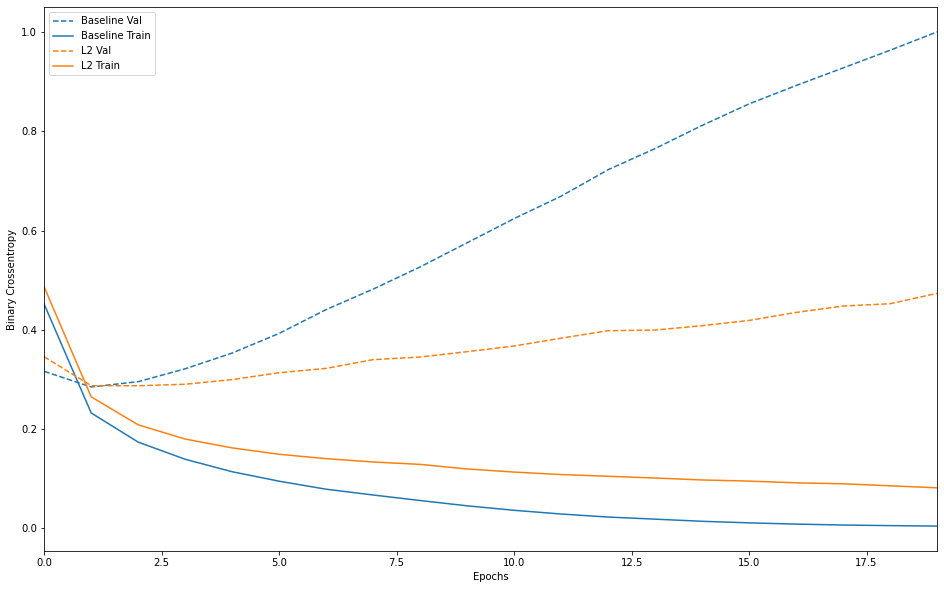

In [29]:
plot_history([('baseline', baseline_history),
              ('l2', l2_model_history)])

### ドロップアウトを追加する

ドロップアウトは、ニューラルネットワークの正則化テクニックとして最もよく使われる手法の一つ。
ドロップアウトは層に適用するもので、訓練時に層から出力された特徴量に対して「ドロップアウト(つまりゼロ化)」を行うもの。
例えば、あるそうが訓練時にある入力サンプルに対して、普通は`[0.2, 0.5, 1.3, 0.8, 1.1]`というベクトルを出力するとする。ドロップアウトを適用すると、このベクトルは例えば`[0, 0.5, 1.3, 0, 1.1]`のようにランダムに散らばったいくつかのゼロを含むようになる。
「ドロップアウト率」はゼロ化される特徴の割合で、通常は0.2～0.5の間に設定する。
テスト時は、どのユニットもドロップアウトされず、代わりに出力値がドロップアウト率と同じ比率でスケールダウンされる。これは訓練時に比べてたくさんのユニットがアクティブであることに対してバランスを取るため。

`tf.keras`では、Dropout層を使ってドロップアウトをネットワークに導入できる。
ドロップアウト層は、その直前の層の出力に対してドロップアウトを適用する。

In [31]:
dpt_model = keras.models.Sequential([
    keras.layers.Dense(16, activation="relu", input_shape=(NUM_WORDS,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation="sigmoid")
])

dpt_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy','binary_crossentropy'])

dpt_model_history = dpt_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 3s - loss: 0.6346 - accuracy: 0.6388 - binary_crossentropy: 0.6346 - val_loss: 0.5274 - val_accuracy: 0.8312 - val_binary_crossentropy: 0.5274
Epoch 2/20
25000/25000 - 2s - loss: 0.4855 - accuracy: 0.8139 - binary_crossentropy: 0.4855 - val_loss: 0.3835 - val_accuracy: 0.8790 - val_binary_crossentropy: 0.3835
Epoch 3/20
25000/25000 - 2s - loss: 0.3840 - accuracy: 0.8783 - binary_crossentropy: 0.3840 - val_loss: 0.3313 - val_accuracy: 0.8874 - val_binary_crossentropy: 0.3313
Epoch 4/20
25000/25000 - 2s - loss: 0.3141 - accuracy: 0.9045 - binary_crossentropy: 0.3141 - val_loss: 0.2996 - val_accuracy: 0.8895 - val_binary_crossentropy: 0.2996
Epoch 5/20
25000/25000 - 2s - loss: 0.2739 - accuracy: 0.9179 - binary_crossentropy: 0.2739 - val_loss: 0.3067 - val_accuracy: 0.8855 - val_binary_crossentropy: 0.3067
Epoch 6/20
25000/25000 - 2s - loss: 0.2363 - accuracy: 0.9322 - binary_crossentropy: 0.2363 - val_loss: 0.2937

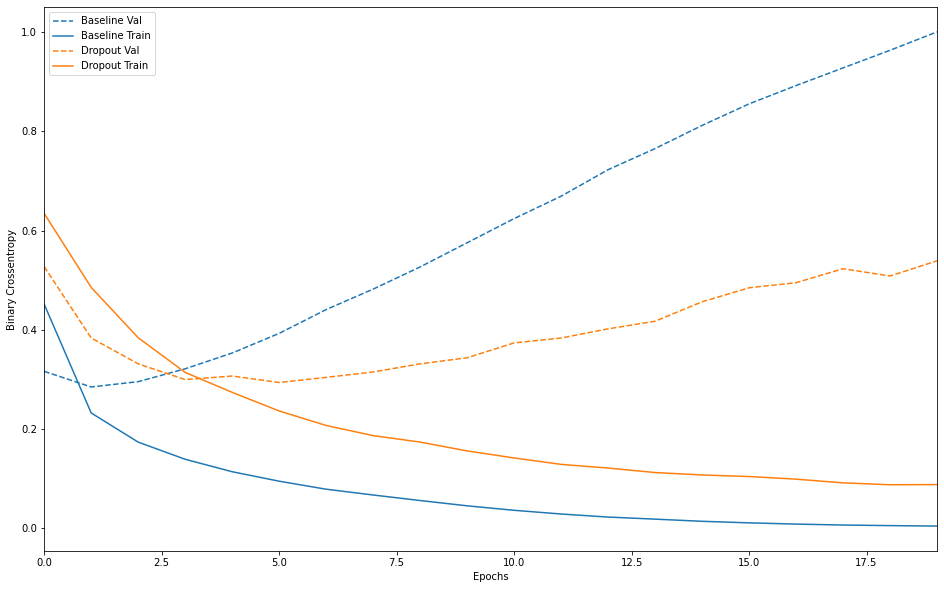

In [32]:
plot_history([('baseline', baseline_history),
              ('dropout', dpt_model_history)])

## まとめ

重みの正則化やドロップアウトの追加によって、比較対象モデルより明らかに改善が見られた。

ニューラルネットワークにおいて過学習を防ぐ最も一般的な方法は以下。

- 訓練データを増やす
- ネットワークの容量を減らす
- 重みの正則化を行う
- ドロップアウトを追加する

このチュートリアルで触れていない2つの重要なアプローチとしては、
「データ拡張」と「バッチ正則化」が残されている。